In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Hfield=pd.read_csv(r"Data\H_field.csv", sep=",")
t=Hfield["t"].tolist()
H=Hfield["H"].tolist()
# Punto 2.a- Comparativa
freq=np.fft.rfftfreq(len(t),t[1]-t[0])
FTT=np.fft.rfft(H)
f_fast=freq[np.argmax(np.abs(FTT))]  #np.argmax(np.abs(FFT)) para obtener la magnitud máxima de FFT

In [20]:
from typing import List
from numpy.typing import NDArray

#Ahora para el cálculo de la frecuencia general:
def Fourier(t:NDArray[float], y:NDArray[float], f:float) -> complex:
  F=0
  for i in range(len(t)):
    F+= y[i]*np.exp(-2j*np.pi*f*t[i])
  return F
frecuencias=np.linspace(0,3,500)
FTT2=[]
for a in range(len(frecuencias)):
    FTT2.append(Fourier(t,H,frecuencias[a])) #Crea una lista con la transformada para cada frecuencia
f_general=frecuencias[np.argmax(np.abs(FTT2))]
print(f"2.a) {f_fast = :.5f}; {f_general = }")

2.a) f_fast = 0.48903; f_general = np.float64(0.49899799599198397)


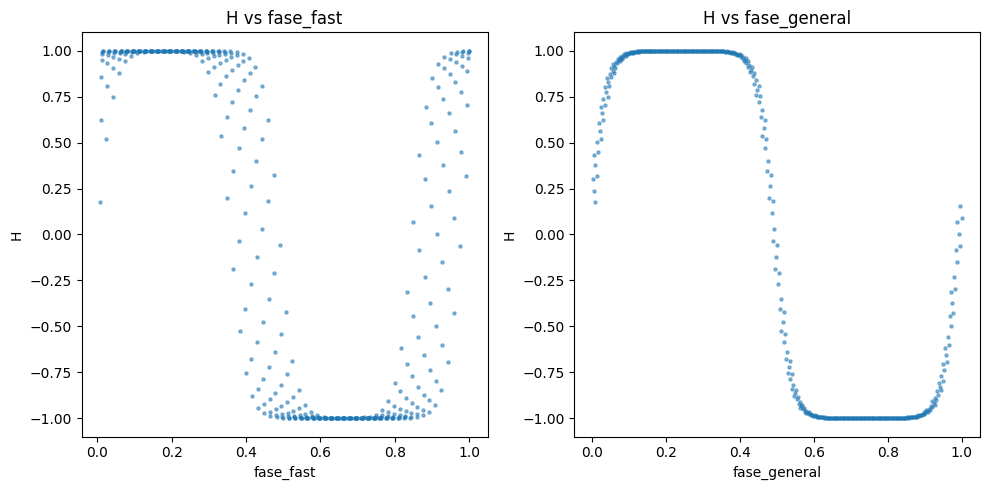

In [21]:
#Para hacer las gráficas:
t=np.array(t)
fase_fast=np.mod(f_fast*t,1) 
fase_general=np.mod(f_general*t,1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(fase_fast, H, alpha=0.5, s=5)
plt.xlabel('fase_fast')
plt.ylabel('H')
plt.title('H vs fase_fast')

plt.subplot(1, 2, 2)
plt.scatter(fase_general, H, alpha=0.5, s=5)
plt.xlabel('fase_general')
plt.ylabel('H')
plt.title('H vs fase_general')

plt.tight_layout()
plt.savefig("2.a.pdf")
plt.show()
    

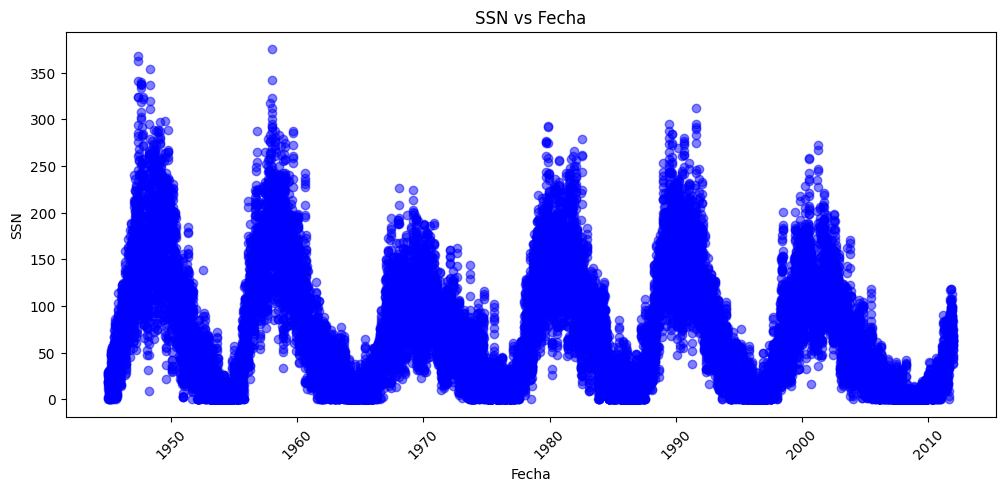

In [ ]:
#Punto 2.b -manchas solares
import pandas as pd
import matplotlib.pyplot as plt
aavso=pd.read_csv(r"Data\list_aavso-arssn_daily.txt",sep=r"\s+",header=None,names=["Year", "Month", "Day", "SSN"])
#con el sep se separa con espacios, y con los demás parámetros se delimitan las columnas
tiempo_aavso=[]
tiempo_normal=[]
SSN=[]
for i in range(len(aavso)):
#El primer if se usó para eliminar las primeras 2 filas que no son datos
    if i>2 and int(aavso.iloc[i,0])<=2012:
        if int(aavso.iloc[i,0])<2012:
          fecha=pd.to_datetime(f"{aavso.iloc[i, 0]}-{aavso.iloc[i, 1]}-{aavso.iloc[i, 2]}",format="%Y-%m-%d")
          tiempo_aavso.append(fecha)
          SSN.append(int(aavso.iloc[i,3]))
          fecha_normal=int(aavso.iloc[i,0])+(int(aavso.iloc[i,1])/12)+(int(aavso.iloc[i,2])/365)
          tiempo_normal.append(fecha_normal)
        else:
          if int(aavso.iloc[i,1])+int(aavso.iloc[i,2])==2:
            fecha=pd.to_datetime(f"{aavso.iloc[i, 0]}-{aavso.iloc[i, 1]}-{aavso.iloc[i, 2]}",format="%Y-%m-%d")
            tiempo_aavso.append(fecha)
            SSN.append(int(aavso.iloc[i,3])) 
            fecha_normal=int(aavso.iloc[i,0])+(int(aavso.iloc[i,1])/12)+(int(aavso.iloc[i,2])/365)
            tiempo_normal.append(fecha_normal)

plt.figure(figsize=(12, 5))  # Ajustar tamaño
plt.scatter(tiempo_aavso, SSN, color="blue", marker="o", alpha=0.5, label="SSN")

plt.xlabel("Fecha")
plt.ylabel("SSN")
plt.title("SSN vs Fecha")
plt.xticks(rotation=45)  # Rotar etiquetas de fecha
plt.show()

In [23]:
#Punto 2.b.a
tiempo_normal=np.array(tiempo_normal)
SSN= np.array(SSN)
freq_aavso=np.fft.rfftfreq(len(tiempo_normal), np.mean(np.diff(tiempo_normal)))  
# No se usó tiempo_normal[1]-tiempo_normal[2] como intervalo de muestreo sino el promedio de las diferencias
FTT_aavso=np.fft.rfft(SSN)
maximo_fourier=np.argmax(np.abs(FTT_aavso[1:]))+1  #Se suma 1 para eliminar el pico del valor 0
frecuencia_dominante=freq_aavso[maximo_fourier]
P_solar=frecuencia_dominante**-1
print(f"2.b.a) {P_solar = } años")

2.b.a) P_solar = np.float64(11.166666368099609) años


2.b.b) n_manchas_hoy = 319


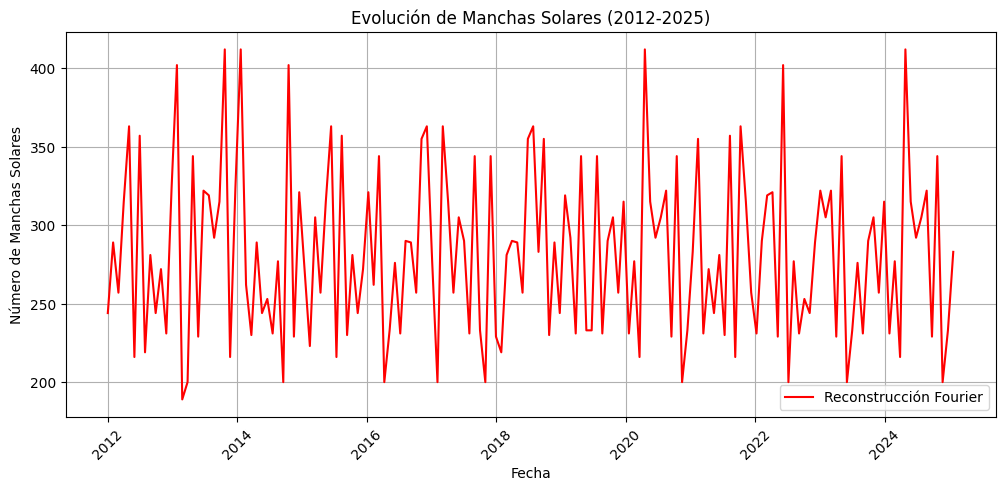

In [24]:
#Punto 2.b.b - prediga el número de manchas solares desde 2012 hasta la fecha de entrega de esta tarea (10 Feb 2025)
import matplotlib.dates as mdates

def inversa(FFT_aavso:np.ndarray, frecuencias:np.ndarray, anio:int, mes:int, dia:int): 
    tiempo=(anio-2012)*365+(mes-1)*30+dia  
    tiempo=tiempo%(11*365) # Período del ciclo solar
    # Tomar solo las componentes más significativas
    N = len(FTT_aavso)
    indices = np.argsort(np.abs(FTT_aavso))[-10:]  #indices de menor a mayor magnitud de la transformada_aavso
    primeros_10=indices[-10:] #primeros 10 coeficientes de mayor magnitud
    y_aavso=0
    for a in primeros_10:
     y_aavso+=(FTT_aavso[a] +np.conj(FTT_aavso[a]))*np.exp(2j*np.pi*freq_aavso[a]*tiempo)
    return round((y_aavso.real)/len(FTT_aavso))

n_manchas_hoy=inversa(FTT_aavso, freq_aavso, 2025, 2, 10)
print(f'2.b.b) {n_manchas_hoy = }')

fechas=np.arange(np.datetime64('2012-01-01'),np.datetime64('2025-02-10'),np.timedelta64(30,'D'))

manchas_reconstruidas=[]
for f in fechas:
    w=inversa(FTT_aavso, freq_aavso, f.astype(object).year, f.astype(object).month, f.astype(object).day)
    manchas_reconstruidas.append(w)

manchas_reconstruidas=np.array(manchas_reconstruidas)
plt.figure(figsize=(12, 5))
plt.plot(fechas, manchas_reconstruidas, color="red", label="Reconstrucción Fourier")
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Etiquetas cada 2 años
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.xlabel("Fecha")
plt.ylabel("Número de Manchas Solares")
plt.title("Evolución de Manchas Solares (2012-2025)")
plt.legend()
plt.grid()
plt.show()

